**Download the Dataset**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Image Augmentation**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import random
import cv2
from tensorflow.keras import layers, models
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import pickle
import zipfile
tf.__version__

'2.9.2'

In [3]:
  !ls

drive  sample_data


In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32
IMAGE_SIZE = [128, 128]
EPOCHS = 25

In [42]:
image = cv2.imread(r'/content/100080576_f52e8ee070_n.jpg')

In [43]:
print(image.shape)

(263, 320, 3)


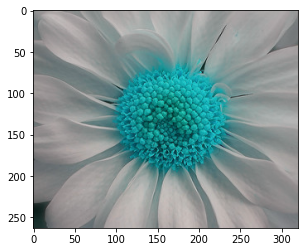

In [44]:
imgplot = plt.imshow(image)
plt.show()

In [45]:
GCS_PATH = "/content/drive/MyDrive/Flowers-Dataset/flowers"

CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(GCS_PATH + "*/*"))])
CLASS_NAMES

array(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'], dtype='<U9')

In [46]:
files_count = []
for i,f in enumerate(CLASS_NAMES):
    folder_path = os.path.join(GCS_PATH, f)
    for path in os.listdir(os.path.join(folder_path)):
        files_count.append(['{}/{}'.format(folder_path,path), f, i])
flowers_df = pd.DataFrame(files_count, columns=['filepath', 'class_name', 'label'])
flowers_df.head()

,filepath,class_name,label
0,/content/drive/MyDrive/Flowers-Dataset/flowers...,sunflower,3
1,/content/drive/MyDrive/Flowers-Dataset/flowers...,sunflower,3
2,/content/drive/MyDrive/Flowers-Dataset/flowers...,sunflower,3
3,/content/drive/MyDrive/Flowers-Dataset/flowers...,sunflower,3
4,/content/drive/MyDrive/Flowers-Dataset/flowers...,sunflower,3


In [47]:
flowers_df.class_name.value_counts()

tulip        984
sunflower    659
Name: class_name, dtype: int64

In [48]:
quantidade_por_class = 500
flowers_df = pd.concat([flowers_df[flowers_df['class_name']== i][:quantidade_por_class] for i in CLASS_NAMES])

In [51]:
flowers_df.class_name.value_counts()

sunflower    500
tulip        500
Name: class_name, dtype: int64

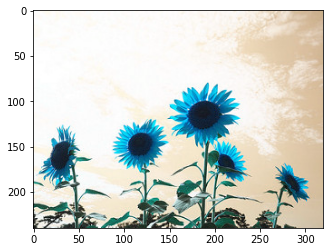

In [52]:
image = cv2.imread(flowers_df.filepath[100])
imgplot = plt.imshow(image)
plt.show()

**Create Model**

In [22]:
X = flowers_df['filepath']
y = flowers_df['label']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [18]:
x_train_tensor = tf.convert_to_tensor(x_train.values, dtype=tf.string)
y_train_tensor = tf.convert_to_tensor(y_train.values)

x_test_tensor = tf.convert_to_tensor(x_test.values, dtype=tf.string)
y_test_tensor = tf.convert_to_tensor(y_test.values)

In [19]:
train_data = tf.data.Dataset.from_tensor_slices((x_train_tensor, y_train_tensor))
test_data = tf.data.Dataset.from_tensor_slices((x_test_tensor, y_test_tensor))

In [20]:
def map_fn(path, label):
    image = tf.image.decode_jpeg(tf.io.read_file(path))

    return image, label

#apply the function
train_data_img = train_data.map(map_fn)
test_data_img = test_data.map(map_fn)

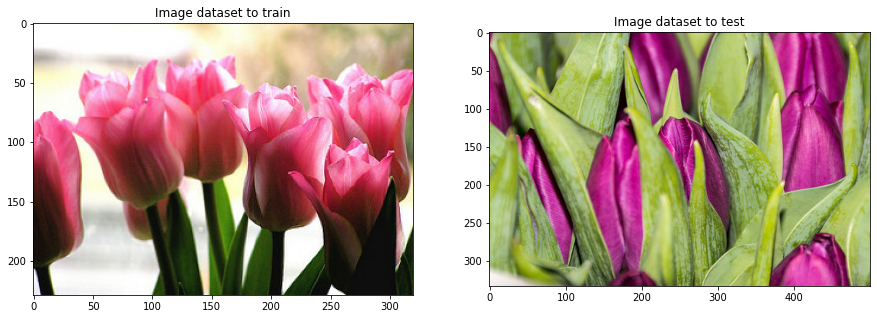

In [21]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
for i,l in train_data_img.take(1):
    ax[0].set_title('Image dataset to train');
    ax[0].imshow(i);
for i,l in test_data_img.take(1):
    ax[1].set_title('Image dataset to test');
    ax[1].imshow(i);

In [23]:
def preprocessing(image, label):
    """
    returns a image that is reshaped and normalized
    """
    image = tf.cast(image, tf.float32)
    image = image / 255.
    image = tf.image.resize(image, IMAGE_SIZE)
    
    return image, label


train_data_norm = train_data_img.map(preprocessing)
test_data_norm = test_data_img.map(preprocessing)

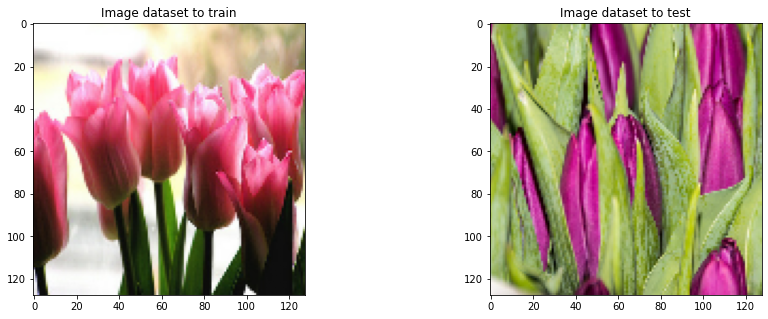

In [24]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
for i,l in train_data_norm.take(1):
    ax[0].set_title('Image dataset to train');
    ax[0].imshow(i);
for i,l in test_data_norm.take(1):
    ax[1].set_title('Image dataset to test');
    ax[1].imshow(i);

In [25]:
train_batches = train_data_norm.batch(batch_size)
test_batches = test_data_norm.batch(batch_size)

for i, l in train_batches.take(1):
    print('Train Data Shape',i.shape)
for i, l in test_batches.take(1):
    print('Test Data Shape',i.shape)

Train Data Shape (32, 128, 128, 3)
Test Data Shape (15, 128, 128, 3)


**Add Layers (Convolution,MaxPooling,Flatten,Dense-(Hidden
Layers),Output)**

In [26]:
LeNet = models.Sequential()
LeNet.add(layers.Conv2D(6, (5,5), activation = 'relu', input_shape = (128, 128, 3)))
LeNet.add(layers.MaxPooling2D())
LeNet.add(layers.Conv2D(16, (5,5), activation = 'relu'))
LeNet.add(layers.MaxPooling2D())
LeNet.add(layers.Flatten())
LeNet.add(layers.Dense(255, activation='relu'))
LeNet.add(layers.Dropout(0.2))
LeNet.add(layers.Dense(124, activation='relu'))
LeNet.add(layers.Dropout(0.2))
LeNet.add(layers.Dense(84, activation='relu'))
LeNet.add(layers.Dense(43, activation='sigmoid'))
LeNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 13456)             0         
                                                                 
 dense (Dense)               (None, 255)               3

**Compile The Model**

In [27]:
LeNet.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

**Fit The Model**

In [28]:
history = LeNet.fit(train_batches, epochs=10,batch_size = 16,validation_data=(test_batches))

Epoch 1/10
2/2 [==============================] - 2s 484ms/step - loss: 3.7537 - accuracy: 0.0857 - val_loss: 1.9402 - val_accuracy: 1.0000
Epoch 2/10
2/2 [==============================] - 1s 271ms/step - loss: 1.9551 - accuracy: 0.8000 - val_loss: 0.1700 - val_accuracy: 1.0000
Epoch 3/10
2/2 [==============================] - 1s 241ms/step - loss: 0.2179 - accuracy: 1.0000 - val_loss: 0.0110 - val_accuracy: 1.0000
Epoch 4/10
2/2 [==============================] - 1s 305ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 3.2051e-04 - val_accuracy: 1.0000
Epoch 5/10
2/2 [==============================] - 1s 258ms/step - loss: 2.8903e-05 - accuracy: 1.0000 - val_loss: 6.0476e-06 - val_accuracy: 1.0000
Epoch 6/10
2/2 [==============================] - 1s 257ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 9.5367e-08 - val_accuracy: 1.0000
Epoch 7/10
2/2 [==============================] - 1s 254ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy:

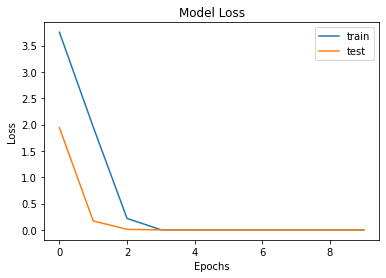

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

**Save the Model**

In [30]:

from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
  
# Load dataset
from sklearn.datasets import load_iris
iris = load_iris()
  
X = iris.data
y = iris.target
  
# Split dataset into train and test
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3,
                     random_state=2018)
  
# import KNeighborsClassifier model
knn = KNN(n_neighbors=3)
  
# train model
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [31]:
import pickle
saved_model = pickle.dumps(knn)
knn_from_pickle = pickle.loads(saved_model)
knn_from_pickle.predict(X_test)

array([0, 1, 1, 1, 0, 1, 2, 1, 2, 0, 0, 2, 2, 2, 0, 2, 2, 0, 1, 1, 1, 0,
       2, 0, 0, 2, 0, 0, 2, 1, 0, 2, 0, 1, 2, 0, 0, 0, 0, 1, 0, 2, 2, 2,
       1])

**Test The Model**

In [32]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

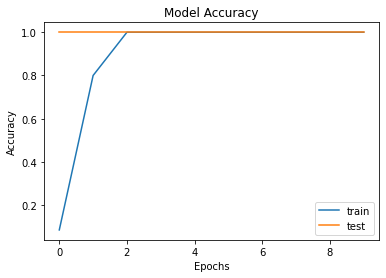

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()